<a href="https://colab.research.google.com/github/biplobsd/clef2022/blob/main/Text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLef 2022 -  CheckThat!** DIU_SpeedOut
Task 3 - Experiment -
Fake News Detection
<br><br><br>

Read More : https://sites.google.com/view/clef2022-checkthat/tasks/task-3-fake-news-detection?authuser=0
<br>
Repo: https://github.com/biplobsd/clef2022
<br>
Source: https://github.com/kshashank231/text-classification


## Libraries and Functions

In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import string

import nltk
import scikitplot as skplt
import matplotlib.pyplot as plt


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree
from sklearn import linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV
import xgboost
from collections import Counter

In [ ]:
#Function to create ROC curve
import matplotlib.pyplot as plt
def plot_roc_curve(fpr,tpr):
    plt.plot([0,1],[0,1],color='darkblue',label='Guessing',linestyle='--')

    plt.plot(fpr,tpr,color='orange',label='ROC')
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Area Under ROC curve')
    plt.show()

In [ ]:
def norm_url(text):  
  return re.sub(r'http\S+|www.\S+|pic.\S+', 'someurl',text.lower())

def norm_email(text):  
  return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', 'someemail',text)

def norm_tag(text):  
  return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', 'somehand',text)

def process_text(text):
  token_words = nltk.word_tokenize(text)
  return token_words

def norm_numbers(words):
  """Replace all interger occurrences in list of tokenized words with somenumber"""
  new_words = []
  for word in words:
      if word.isdigit():
          new_word = 'somenumber'
          new_words.append(new_word)
      else:
          new_words.append(word)
  return new_words


def remove_non_ascii(words):
  """Remove non-ASCII characters from list of tokenized words"""
  new_words = []
  for word in words:
      new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
      new_words.append(new_word)
  return new_words

def to_lowercase(words):
  """Convert all characters to lowercase from list of tokenized words"""
  new_words = []
  for word in words:
      new_word = word.lower()
      new_words.append(new_word)
  return new_words


def remove_punctuation(words):
  """Remove punctuation from list of tokenized words"""
  new_words = []
  for word in words:
      new_word = re.sub(r'[^\w\s]', '', word)
      if new_word != '':
          new_words.append(new_word)
  return new_words

def replace_numbers(words):
  """Replace all interger occurrences in list of tokenized words with textual representation"""
  p = inflect.engine()
  new_words = []
  for word in words:
      if word.isdigit():
          new_word = p.number_to_words(word)
          new_words.append(new_word)
      else:
          new_words.append(word)
  return new_words

def remove_stopwords(words):
  """Remove stop words from list of tokenized words"""
  new_words = []
  for word in words:
      if word not in stopwords.words('english'):
          new_words.append(word)
  return new_words

def stem_words(words):
  """Stem words in list of tokenized words"""
  stemmer = LancasterStemmer()
  stems = []
  for word in words:
      stem = stemmer.stem(word)
      stems.append(stem)
  return stems

def lemmatize_verbs(words):
  """Lemmatize verbs in list of tokenized words"""
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word in words:
      lemma = lemmatizer.lemmatize(word, pos='v')
      lemmas.append(lemma)
  return lemmas

def normalize(text):

  words = process_text(text)
  words = norm_numbers(words)
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
  words = remove_stopwords(words)
  # words = stem_words(words)
  words = lemmatize_verbs(words)
  return words

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = (np.trace(cf) / float(np.sum(cf))) * 100

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.2f} %\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
pd.set_option('display.max_colwidth', 50)

In [ ]:
# Dataset is Restricted for shearing 
# Access Request https://zenodo.org/record/6508748
# !gdown 
# !gdown 

In [ ]:
df = pd.read_csv('combine.csv')
df

,public_id,text,title,our rating
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",FALSE
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,partially false
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,partially false
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,FALSE
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,FALSE
...,...,...,...,...
1259,47423bb6,More than four million calls to the taxman are...,Taxman fails to answer four million calls a ye...,true
1260,097c142a,More under-18s are being taken to court for se...,Police catch 11‑year‑olds being used to sell d...,true
1261,08bc59f4,The Government’s much vaunted Help to Buy Isa ...,"Help to Buy Isa scandal: 500,000 first-time bu...",false
1262,af3393ce,The late Robin Williams once called cocaine “G...,A coke-snorting generation of hypocrites,true


In [ ]:
df.shape

(1264, 4)

In [ ]:
df.drop(labels='public_id',axis=1, inplace=True)

In [ ]:
df

,text,title,our rating
0,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",FALSE
1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,partially false
2,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,partially false
3,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,FALSE
4,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,FALSE
...,...,...,...
1259,More than four million calls to the taxman are...,Taxman fails to answer four million calls a ye...,true
1260,More under-18s are being taken to court for se...,Police catch 11‑year‑olds being used to sell d...,true
1261,The Government’s much vaunted Help to Buy Isa ...,"Help to Buy Isa scandal: 500,000 first-time bu...",false
1262,The late Robin Williams once called cocaine “G...,A coke-snorting generation of hypocrites,true


In [ ]:
df.isnull().sum()

text           0
title         23
our rating     0
dtype: int64

In [ ]:
df = df.rename(columns={'our rating':'label'})
df['label'] = df.label.map({'TRUE': 1,'true':1, 'FALSE': 0,'false':0, 'partially false': 2, 'other': 3})

In [ ]:
df.groupby('label').count()

,text,title
label,,
0,578,571
1,211,206
2,358,349
3,117,115


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1264 non-null   object
 1   title   1241 non-null   object
 2   label   1264 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 29.8+ KB


In [ ]:
df

,text,title,label
0,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",0
1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,2
2,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,2
3,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,0
4,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,0
...,...,...,...
1259,More than four million calls to the taxman are...,Taxman fails to answer four million calls a ye...,1
1260,More under-18s are being taken to court for se...,Police catch 11‑year‑olds being used to sell d...,1
1261,The Government’s much vaunted Help to Buy Isa ...,"Help to Buy Isa scandal: 500,000 first-time bu...",0
1262,The late Robin Williams once called cocaine “G...,A coke-snorting generation of hypocrites,1


## Complete Dataset

In [ ]:
df_tmp = df

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_tmp.drop('label',axis=1),df_tmp.label,random_state =42)

In [ ]:
import numpy as np
a = np.random.rand(4,3)
b = np.random.rand(3,1)

In [ ]:
np.sum(a,axis=1).shape

(4,)

## 1. Using Count Vectorizer Features

In [ ]:
import math
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer=normalize)
xtrain_count = count_vect.fit_transform(X_train['title'].replace(math.nan,' ') + ' ' + X_train['text'])
xtest_count =  count_vect.transform(X_test['title'].replace(math.nan,' ') + ' ' + X_test['text'])

count_vect_full = CountVectorizer(analyzer=normalize)
xfull_count = count_vect_full.fit_transform(df_tmp['title'].replace(math.nan,' ') + ' ' + df_tmp['text'])
xtest_count_full =  count_vect_full.transform(X_test['title'].replace(math.nan,' ') + ' ' + X_test['text'])


### Naive Bayes Classifier

#### Model

In [ ]:
nbc = naive_bayes.MultinomialNB()
nbc.fit(xtrain_count,y_train)
y_preds = nbc.predict(xtest_count)

0.6582278481012658

              precision    recall  f1-score   support

           0       0.73      0.85      0.78       141
           1       0.61      0.53      0.56        59
           2       0.56      0.59      0.57        90
           3       0.80      0.15      0.26        26

    accuracy                           0.66       316
   macro avg       0.67      0.53      0.54       316
weighted avg       0.66      0.66      0.64       316




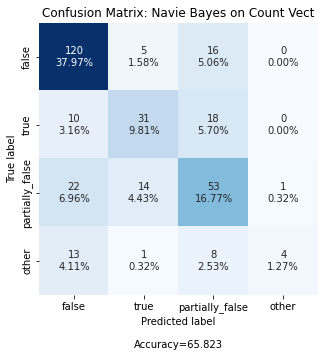

In [ ]:
print(accuracy_score(y_test,y_preds))
print()
print(classification_report(y_test,y_preds))
cf_matrix_1 =confusion_matrix(y_test,y_preds)
# print(cf_matrix_1)
print()
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['false','true', 'partially_false', 'other']
make_confusion_matrix(cf_matrix_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False,title='Confusion Matrix: Navie Bayes on Count Vect')

#### Submission

In [ ]:

df_raw = pd.read_csv('English_data_test_release.csv')

df_raw_sub = df_raw

# Using Count Vectorizer Features
df_raw_sub_count = count_vect_full.transform(df_raw_sub['title'].replace(math.nan,' ') + ' ' + df_raw_sub['text'])

# Using word level tf-idf Features
df_raw_sub_tfidf = tfidf_vect_full.transform(df_raw_sub_count)


In [ ]:
m = lr.predict(df_raw_sub_tfidf)

In [ ]:
predict = []
label = ['false', 'true', 'partially false', 'other']
for p in m:
  predict.append(label[p])
df_raw['predicted_rating'] = predict

In [ ]:
df_raw

,ID,text,title,predicted_rating
602,147575044263640448705296981827539520951,Turkish land forces have advanced into Syria t...,Turkey Steps Up Offensive Against Syrian Kurdi...,partially false
603,226286523808954494317699147543855854671,Queens state Sen. Jose Peralta suffered sudden...,New York State Senator Jose Peralta’s cause of...,false
604,138479109015113776387811964986651898271,As news and misinformation about the COVID-19 ...,Nearly three-in-ten Americans believe COVID-19...,false
605,55125174276315764619221784966218263337,SLIM MARGIN: A new survey shows slightly more ...,New Polling Shows More Australians Want Scott ...,false
606,270077888906743054673881300019061126049,Health Minister Christian Dubé hopes the measu...,Quebec's liquor and cannabis stores will requi...,partially false
607,206921579192720402152220292846254137866,DISTRIBUTE TO EVERYONE who does not want to be...,"‘From October 20, the Covid pass and vaccinati...",false
608,26464356958085668535128110139955868781,The physician who served as Bill Gates’ privat...,Bill Gates' Former Doctor Says He 'Refused To ...,false
609,189700315351432315169761694613833047445,"A customer leaves an SAQ outlet on Jan. 6, the...",Quebec’s expansion of COVID-19 vaccine passpor...,false
610,188373492569049166266633359075598402208,Vaccine coercion activists are using the fake ...,ALERT: Luc Montagnier Did NOT Say Vaccine Woul...,false
611,337277576050638215330059360481185892501,Placeholder while article actions load Quebec...,"Quebec’s cannabis, liquor stores to require co...",false


In [ ]:
!rm -rf /content/subtask3_english_DIU_SpeedOut.zip /content/subtask3_english_DIU_SpeedOut.tsv
teamName = 'DIU_SpeedOut'
fileName = f'subtask3_english_{teamName}'
df_raw.to_csv(f'{fileName}.tsv', sep='\t', index=False)
fileNameZip = f'{fileName}.zip'
fileNameTsv = f'{fileName}.tsv'
!zip $fileNameZip $fileNameTsv

  adding: subtask3_english_DIU_SpeedOut.tsv (deflated 64%)


## Using word level tf-idf Features


In [ ]:
# word level tf-idf

tfidf_vect = TfidfTransformer()
xtrain_tfidf = tfidf_vect.fit_transform(xtrain_count)
xtest_tfidf =  tfidf_vect.transform(xtest_count)

tfidf_vect_full = TfidfTransformer()
xfull_tfidf = tfidf_vect_full.fit_transform(xfull_count)
xtest_tfidf_full =  tfidf_vect_full.transform(xtest_count_full)


### Logistic regression

#### Model

In [ ]:
lr = linear_model.LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(xtrain_tfidf, y_train)
y_preds = lr.predict(xtest_tfidf)

0.6518987341772152



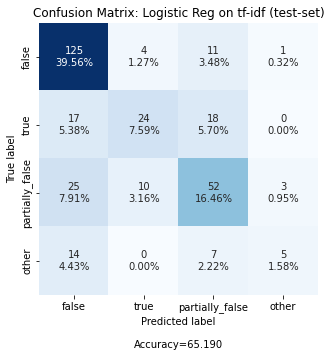

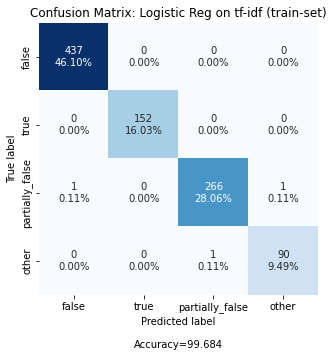

In [ ]:
print(accuracy_score(y_test,y_preds))
print()

# print(classification_report(y_test,y_preds))
cf_matrix_7 =confusion_matrix(y_test,y_preds)
# print(cf_matrix_7)
# labels = ['True Neg','False Pos','False Neg','True Pos']
# categories = ['REAL', 'FAKE']
make_confusion_matrix(cf_matrix_7, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False,title='Confusion Matrix: Logistic Reg on tf-idf (test-set)' )
make_confusion_matrix(confusion_matrix(y_train,lr.predict(xtrain_tfidf)), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False,title='Confusion Matrix: Logistic Reg on tf-idf (train-set)')

#### Submission

In [ ]:
df_raw = pd.read_csv('English_data_test_release.csv')

df_raw_sub = df_raw

# Using Count Vectorizer Features
df_raw_sub_count = count_vect_full.transform(df_raw_sub['title'].replace(math.nan,' ') + ' ' + df_raw_sub['text'])

# Using word level tf-idf Features
df_raw_sub_tfidf = tfidf_vect_full.transform(df_raw_sub_count)


In [ ]:
m = lr.predict(df_raw_sub_tfidf)

In [ ]:
predict = []
label = ['false', 'true', 'partially false', 'other']
for p in m:
  predict.append(label[p])
df_raw['predicted_rating'] = predict

In [ ]:
df_raw

,ID,text,title,predicted_rating
602,147575044263640448705296981827539520951,Turkish land forces have advanced into Syria t...,Turkey Steps Up Offensive Against Syrian Kurdi...,partially false
603,226286523808954494317699147543855854671,Queens state Sen. Jose Peralta suffered sudden...,New York State Senator Jose Peralta’s cause of...,false
604,138479109015113776387811964986651898271,As news and misinformation about the COVID-19 ...,Nearly three-in-ten Americans believe COVID-19...,false
605,55125174276315764619221784966218263337,SLIM MARGIN: A new survey shows slightly more ...,New Polling Shows More Australians Want Scott ...,false
606,270077888906743054673881300019061126049,Health Minister Christian Dubé hopes the measu...,Quebec's liquor and cannabis stores will requi...,partially false
607,206921579192720402152220292846254137866,DISTRIBUTE TO EVERYONE who does not want to be...,"‘From October 20, the Covid pass and vaccinati...",false
608,26464356958085668535128110139955868781,The physician who served as Bill Gates’ privat...,Bill Gates' Former Doctor Says He 'Refused To ...,false
609,189700315351432315169761694613833047445,"A customer leaves an SAQ outlet on Jan. 6, the...",Quebec’s expansion of COVID-19 vaccine passpor...,false
610,188373492569049166266633359075598402208,Vaccine coercion activists are using the fake ...,ALERT: Luc Montagnier Did NOT Say Vaccine Woul...,false
611,337277576050638215330059360481185892501,Placeholder while article actions load Quebec...,"Quebec’s cannabis, liquor stores to require co...",false


In [ ]:
!rm -rf /content/subtask3_english_DIU_SpeedOut.zip /content/subtask3_english_DIU_SpeedOut.tsv
teamName = 'DIU_SpeedOut'
fileName = f'subtask3_english_{teamName}'
df_raw.to_csv(f'{fileName}.tsv', sep='\t', index=False)
fileNameZip = f'{fileName}.zip'
fileNameTsv = f'{fileName}.tsv'
!zip $fileNameZip $fileNameTsv

  adding: subtask3_english_DIU_SpeedOut.tsv (deflated 64%)


### SGD classifier

#### Model

0.6550632911392406

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       141
           1       0.63      0.44      0.52        59
           2       0.61      0.58      0.59        90
           3       0.42      0.19      0.26        26

    accuracy                           0.66       316
   macro avg       0.59      0.52      0.54       316
weighted avg       0.64      0.66      0.63       316




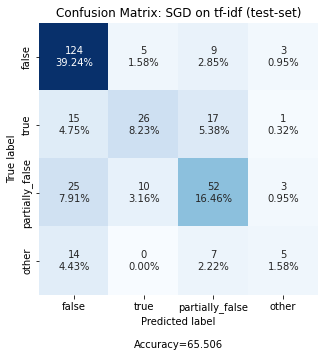

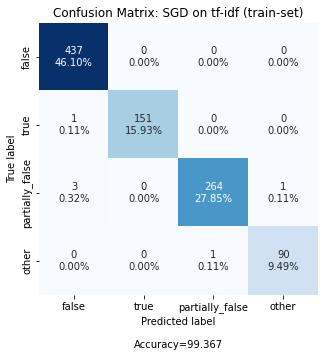

In [ ]:
clf = SGDClassifier(random_state=42)
clf.fit(xtrain_tfidf,y_train)
y_preds = clf.predict(xtest_tfidf)
print(accuracy_score(y_test,y_preds))
print()
print(classification_report(y_test,y_preds))
cf_1 =confusion_matrix(y_test,y_preds)
# print(cf_1)
print()
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['false','true', 'partially_false', 'other']
make_confusion_matrix(cf_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False,title='Confusion Matrix: SGD on tf-idf (test-set)')
make_confusion_matrix(confusion_matrix(y_train,clf.predict(xtrain_tfidf)), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False,title='Confusion Matrix: SGD on tf-idf (train-set)')

#### Submission

In [ ]:
df_raw = pd.read_csv('English_data_test_release.csv')

df_raw_sub = df_raw

# Using Count Vectorizer Features
df_raw_sub_count = count_vect_full.transform(df_raw_sub['title'].replace(math.nan,' ') + ' ' + df_raw_sub['text'])

# Using word level tf-idf Features
df_raw_sub_tfidf = tfidf_vect_full.transform(df_raw_sub_count)


In [ ]:
m = clf.predict(df_raw_sub_tfidf)

In [ ]:
predict = []
label = ['false', 'true', 'partially false', 'other']
for p in m:
  predict.append(label[p])
df_raw['predicted_rating'] = predict

In [ ]:
df_raw

,ID,text,title,predicted_rating
0,122653045997905671927713471889615536378,The deputy secretary at the US Treasury has sa...,US Treasury deputy sec warns that shortages li...,false
1,275389285957305997321446227088442471741,KABUL—Approximately twelve minutes after U.S. ...,CNN Praises Taliban For Wearing Masks During A...,false
2,333248764296609831067233855420575814716,The vast majority of (oblivious) Americans hav...,Tennessee Has Just LEGALIZED Government COVID ...,false
3,264019763253447756851916399533799891538,(Natural News) There’s a secret layer of infor...,MEDICAL SHOCKER: Scientists at Sloan Kettering...,false
4,158073737187690682830899773280916034317,"A recent study reported by the NCBI, which is ...",Study Results: Facemasks are Ineffective to Bl...,partially false
...,...,...,...,...
607,206921579192720402152220292846254137866,DISTRIBUTE TO EVERYONE who does not want to be...,"‘From October 20, the Covid pass and vaccinati...",false
608,26464356958085668535128110139955868781,The physician who served as Bill Gates’ privat...,Bill Gates' Former Doctor Says He 'Refused To ...,false
609,189700315351432315169761694613833047445,"A customer leaves an SAQ outlet on Jan. 6, the...",Quebec’s expansion of COVID-19 vaccine passpor...,false
610,188373492569049166266633359075598402208,Vaccine coercion activists are using the fake ...,ALERT: Luc Montagnier Did NOT Say Vaccine Woul...,false


In [ ]:
!rm -rf /content/subtask3_english_DIU_SpeedOut.zip /content/subtask3_english_DIU_SpeedOut.tsv
teamName = 'DIU_SpeedOut'
fileName = f'subtask3_english_{teamName}'
df_raw.to_csv(f'{fileName}.tsv', sep='\t', index=False)
fileNameZip = f'{fileName}.zip'
fileNameTsv = f'{fileName}.tsv'
!zip $fileNameZip $fileNameTsv

  adding: subtask3_english_DIU_SpeedOut.tsv (deflated 64%)
